In [95]:
import pandas as pd
row_data = pd.read_excel('cloze_task_raw_data.xlsx')
print(row_data.shape)
row_data = row_data[row_data['shown'] != 'Введите первое слово']
print(row_data.shape)

(64645, 16)
(57836, 16)


In [96]:
def clear(x):
    flag=0
    if (len(x)==1) and (x not in 'ксявуоиа'):
        flag+=1
    for i in x:
        if i not in 'ячсмитьбюэждлорпавыфйцукенгшщзхъЯЧСМИТЬБЮФЫВАПРОЛДЖЭЪХЗЩЙЦШУГКНЕ':
             flag+=1
    if flag==0:
        return x
    else:
        return 0
row_data.answer = row_data.answer.astype(str)
row_data.answer = row_data.answer.apply(clear)
row_data = row_data[row_data['answer']!=0]
row_data.shape

(57346, 16)

In [97]:
data = row_data[['shown','answer','word.id']]
k = data[['shown','word.id']].drop_duplicates()
k.shape

(1222, 2)

In [98]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def pos_t_cor_w(cor_w):
    ps = {}
    for indx, pos_variant in enumerate(morph.parse(cor_w)):
        if pos_variant.tag.POS not in ps:
            ps[pos_variant.tag.POS] = pos_variant.score
        else:
            ps[pos_variant.tag.POS] += pos_variant.score
            
    return list(ps.items())

In [100]:
correct_word_tags = {}
for context, word in list(zip( k['shown'].tolist(), k['word.id'].tolist())):
    correct_word_tags[(context,word)] = pos_t_cor_w(word)

In [101]:
list(correct_word_tags.items())[:10]
len(list(correct_word_tags.items()))

1222

In [102]:
def tolist_(x):
    return [x]
data.answer = data.answer.apply(tolist_)

/home/semen/.local/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [103]:
nt = data[['shown', 'answer', 'word.id']].groupby(['shown', 'word.id']).sum()
nt = nt.reset_index()
nt.head()


shown    word.id  \
0                               А  промывать   
1                     А промывать     манную   
2              А промывать манную      крупу   
3        А промывать манную крупу      перед   
4  А промывать манную крупу перед        тем   

                                              answer  
0  [вот, где, ему, зачем, знаете, зори, когда, кт...  
1  [глаза, горло, желудок, ли, макароны, мозги, м...  
2  [кашу, кашу, кашу, кашу, кашу, кашу, кашу, каш...  
3  [блин, лучше, лучше, не, не, не, не, не, не, н...  
4  [варкой, варкой, варкой, варкой, варкой, варко...

In [104]:
f = list(zip(nt['shown'].tolist(), nt['word.id'].tolist()))
answer_dict = {}
for indx,i in enumerate(f):
    answer_dict[i] = nt.answer.tolist()[indx] 

In [105]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def pos_t_ans(true_tag_distr, answers):
    normalize = len(answers)
    res = 0
    for answer in answers:
        ps = {}
        for indx, pos_variant in enumerate(morph.parse(answer)):
            if pos_variant.tag.POS not in ps:
                ps[pos_variant.tag.POS] = pos_variant.score
            else:
                ps[pos_variant.tag.POS] += pos_variant.score
     
        for tag, prob in true_tag_distr:
            if tag in ps:
                res += ps[tag]*prob
    res /=normalize     
        
    return res

In [106]:
i = 0
res = []
for cont_word, answers in answer_dict.items():
    res.append(pos_t_ans(correct_word_tags[cont_word],answers))
print(len(res))
        

1222


In [107]:
nt.head(10)

shown    word.id  \
0                                                  А  промывать   
1                                        А промывать     манную   
2                                 А промывать манную      крупу   
3                           А промывать манную крупу      перед   
4                     А промывать манную крупу перед        тем   
5                А промывать манную крупу перед тем‚        как   
6            А промывать манную крупу перед тем‚ как     варить   
7     А промывать манную крупу перед тем‚ как варить         ее   
8  А промывать манную крупу перед тем‚ как варить...         не   
9  А промывать манную крупу перед тем‚ как варить...  пробовали   

                                              answer  
0  [вот, где, ему, зачем, знаете, зори, когда, кт...  
1  [глаза, горло, желудок, ли, макароны, мозги, м...  
2  [кашу, кашу, кашу, кашу, кашу, кашу, кашу, каш...  
3  [блин, лучше, лучше, не, не, не, не, не, не, н...  
4  [варкой, варкой, варкой, варкой, варкой, варко...  
5  [как, как, как, как, как, как, как, как, как, ...  
6  [варить, варить, варить, варить, варить, варит...  
7  [ее, ее, ее, ее, из, кашу, кашу, кашу, кашу, н...  
8  [надо, надо, надо, не, не, не, не, не, не, не,...  
9  [имеет, надо, надо, надо, надо, нужно, нужно, ...

In [110]:
nt['prob'] = res

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


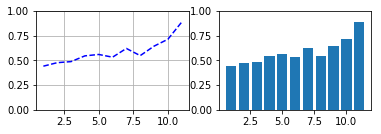

In [112]:
import matplotlib.pyplot as plt 

plot_data = nt[['shown', 'prob']]
def get_len(x):
    return len(x.split())

def plot_mean_prob_distribution(plot_data):
    plot_data['context_len'] = plot_data.shown.apply(get_len)
    x1 = plot_data.groupby('context_len').sum()
    x1 = x1.reset_index(level=['context_len'])
    x2 = plot_data.groupby('context_len').size()
    x2 = x2.reset_index(level=['context_len'])
    plotting = x1.merge(x2, left_on = 'context_len', right_on = 'context_len', how = 'outer')
    plotting.columns = ['context_len', 'prob', 'abs_freq']
    plotting['frequency'] = plotting['prob']/plotting['abs_freq']
    
    plt.subplot(221)
    plot1, =plt.plot(plotting.context_len.tolist(), plotting.frequency.tolist(), 'b--', label="$y=x^2$")
    plt.ylim(0,1)
    plt.grid()

    plt.subplot(222)
    plt.bar(x= plotting.context_len.tolist(), height = plotting.frequency.tolist())
    plt.ylim(0,1)

    _=plt.show()
    
plot_mean_prob_distribution(plot_data)

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


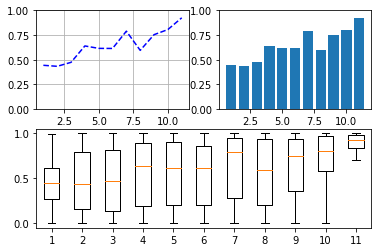

In [114]:
import numpy as np

def tl(x):
    d = []
    d.append(x)
    return d

def mediann(x):
    return np.median(x)

def plot_median_distribution(plot_data):
    
    plot_data['context_len'] = plot_data.shown.apply(get_len)
    plot_data.prob = plot_data.prob.apply(tl)
    x1 = plot_data.groupby('context_len').sum()
    x1 = x1.reset_index(level=['context_len'])
    plotting = x1

    plotting['mediann'] = plotting['prob'].apply(mediann)
    
    data = np.array(plotting.prob)

    plt.subplot(221)
    plot1, =plt.plot(plotting.context_len.tolist(), plotting.mediann.tolist(), 'b--', label="$y=x^2$")
    plt.ylim(0,1)
    plt.grid()

    plt.subplot(222)
    plt.bar(x= plotting.context_len.tolist(), height = plotting.mediann.tolist())
    plt.ylim(0,1)
    
    plt.subplot(212)
    plt.boxplot(data)
    

    _=plt.show()

    
plot_median_distribution(plot_data)

In [115]:
!ls

'1james_f_statistical_methods_in_experimental_physics (1).djvu'
 atricals
 cloze_task_average_accuracy.xlsx
 cloze_task_raw_data.xlsx
 Compare_data.ipynb
 data.json
 diction_for_tag_replacing.ipynb
 LSTM_probability.xlsx
 LSTM_prob_w_pos.xlsx
 moreThan2tag.txt
 new_comparing_files
 new_comparing.ipynb
 new_comparing.md
 output.xlsx
'prob_tag_with_ pymorphy.ipynb'
 res.csv
 result_tag_new.xls
 result_tag_new.xlsx
 result_tag_to_compare.xlsx
 result_tag.xls
 tag_clearing.ipynb
 Tag_cloze_task.ipynb
 Tag_comparing.ipynb
 tags_distr.xlsx
 Untitled1.ipynb


In [116]:
import json
json_data=open('data.json').read()

data = json.loads(json_data)
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [117]:
data

{'на': [['самом', 0.05641793832182884],
  ['этом', 0.04065895825624466],
  ['следующий', 0.025201721116900444],
  ['этот', 0.023421332240104675],
  ['другой', 0.021387994289398193],
  ['днях', 0.01698158122599125],
  ['этой', 0.015726767480373383],
  ['это', 0.015085463412106037],
  ['первом', 0.014315631240606308],
  ['<UNK>', 0.011320417746901512],
  ['прошлой', 0.010573669336736202],
  ['втором', 0.009326505474746227],
  ['его', 0.00855707935988903],
  ['сей', 0.00841954629868269],
  ['основании', 0.008402076549828053],
  ['сегодняшний', 0.00822276622056961],
  ['вопрос', 0.007389082573354244],
  ['нем', 0.006941877771168947],
  ['борту', 0.006651763338595629],
  ['первый', 0.00658325245603919],
  ['эти', 0.0065013449639081955],
  ['что', 0.006120171397924423],
  ['«', 0.005998099688440561],
  ['мой', 0.005760075990110636],
  ['второй', 0.005474018398672342],
  ['территории', 0.005266969092190266],
  ['фоне', 0.005176038481295109],
  ['ней', 0.0050929831340909],
  ['них', 0.00503606